<a href="https://colab.research.google.com/github/PriyankaVerma98/Neural_networks_TensorFlow/blob/master/Time_series_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
link = 'https://drive.google.com/open?id=1fANFUiToJV162LN3LZeYkuOawcolw0iQ'
fluff, id = link.split('=')
print (id)

1fANFUiToJV162LN3LZeYkuOawcolw0iQ


In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
import pandas as pd


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Cleaned_Data2017-18.csv')  
df2 = pd.read_csv('Cleaned_Data2017-18.csv')

In [0]:
downloaded2 = drive.CreateFile({'id':id}) 
downloaded2.GetContentFile('Cleaned_Data2016-17.csv')  
df1 = pd.read_csv('Cleaned_Data2016-17.csv')

In [47]:
df1.head(5)

,Unnamed: 0,Commodity,Report Date,State,Market Center,Arrivals(in tonnes),Unit of Arrivals,Origin,Variety,Minimum Prices(in Rs/quintals),Maximum Prices(in Rs/quintals),Modal Prices(in Rs/quintals),Unit of Price,Arrival_Tonnes_Calc,count,Arrival_per_Varitey_Tonnes,Arrival_Quintals_Variety,Crop_code,Commodity Type,Common_Commodity_Name,New_District,District_Code,Commom_District_Name
0,0,Paddy-Dhan-Common,20170401,Andhra Pradesh,Bobbili,0.1,Tonnes,NR,1001,1470.0,1500.0,1490.0,Rs/Quintal,0.1,1,0.1,1.0,101,Cereals,Paddy(Dhan),Adilabad,532,Adilabad
1,1,Paddy-Dhan-Common,20170402,Andhra Pradesh,Bobbili,0.1,Tonnes,NR,1001,1470.0,1490.0,1480.0,Rs/Quintal,0.1,1,0.1,1.0,101,Cereals,Paddy(Dhan),Adilabad,532,Adilabad
2,2,Paddy-Dhan-Common,20170403,Andhra Pradesh,Bobbili,0.1,Tonnes,NR,1001,1470.0,1490.0,1480.0,Rs/Quintal,0.1,1,0.1,1.0,101,Cereals,Paddy(Dhan),Adilabad,532,Adilabad
3,3,Paddy-Dhan-Common,20170404,Andhra Pradesh,Bobbili,NR,Tonnes,NR,1001,1470.0,1490.0,1480.0,Rs/Quintal,NaN,1,NaN,NaN,101,Cereals,Paddy(Dhan),Adilabad,532,Adilabad
4,4,Paddy-Dhan-Common,20170405,Andhra Pradesh,Bobbili,31.4,Tonnes,NR,B P T,1511.0,1540.0,1530.0,Rs/Quintal,31.4,1,31.4,314.0,101,Cereals,Paddy(Dhan),Adilabad,532,Adilabad


In [0]:
df1.dropna(subset=['Modal Prices(in Rs/quintals)'],inplace=True)

In [0]:
df2.dropna(subset=['Modal Prices(in Rs/quintals)'],inplace=True)

In [0]:
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping


In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
df1['date'] = pd.to_datetime(df1['Report Date'].astype('str'), yearfirst= True )
# pd.to_datetime(yearfirst=True,   )

In [0]:
df2['date'] = pd.to_datetime(df2['Report Date'].astype('str'), yearfirst= True )


In [0]:
df1a = df1[['Unnamed: 0', 'date', 'Commodity', 'State', 'Market Center', 'Modal Prices(in Rs/quintals)', 'Arrival_Tonnes_Calc']]
df2a = df2[['Unnamed: 0', 'date', 'Commodity', 'State', 'Market Center', 'Modal Prices(in Rs/quintals)', 'Arrival_Tonnes_Calc']]

In [55]:
df1a.head()

,Unnamed: 0,date,Commodity,State,Market Center,Modal Prices(in Rs/quintals),Arrival_Tonnes_Calc
0,0,2017-04-01,Paddy-Dhan-Common,Andhra Pradesh,Bobbili,1490.0,0.1
1,1,2017-04-02,Paddy-Dhan-Common,Andhra Pradesh,Bobbili,1480.0,0.1
2,2,2017-04-03,Paddy-Dhan-Common,Andhra Pradesh,Bobbili,1480.0,0.1
3,3,2017-04-04,Paddy-Dhan-Common,Andhra Pradesh,Bobbili,1480.0,NaN
4,4,2017-04-05,Paddy-Dhan-Common,Andhra Pradesh,Bobbili,1530.0,31.4


In [0]:
df1b= df1a[df1a["Commodity"]== 'Onion']

In [72]:
df1b.head()

,Unnamed: 0,date,Commodity,State,Market Center,Modal Prices(in Rs/quintals),Arrival_Tonnes_Calc
6108,6108,2017-11-02,Onion,Andhra Pradesh,Ichapuram,1400.0,16.0
6109,6109,2017-11-05,Onion,Andhra Pradesh,Ichapuram,1400.0,16.0
6110,6110,2017-11-07,Onion,Andhra Pradesh,Ichapuram,1400.0,16.0
6111,6111,2017-11-08,Onion,Andhra Pradesh,Ichapuram,1400.0,16.0
6112,6112,2017-10-17,Onion,Andhra Pradesh,Ichapuram,1000.0,16.0


**Statistical** **Normality** **Test**


In [57]:
stat, p = stats.normaltest(df1b["Modal Prices(in Rs/quintals)"] )
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=79783.258, p=0.000
Data does not look Gaussian (reject H0)


In [0]:
import seaborn as sns

Kurtosis of normal distribution: 8.620618091612767
Skewness of normal distribution: 2.118286546370733


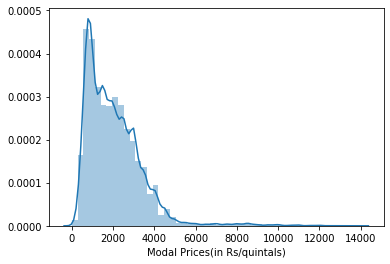

In [62]:
sns.distplot(df1b["Modal Prices(in Rs/quintals)"]);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df1b["Modal Prices(in Rs/quintals)"])))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df1b["Modal Prices(in Rs/quintals)"])))

Parametric statistical methods assume that the data has a known and specific distribution, often a Gaussian distribution. If a data sample is not Gaussian, then the assumptions of parametric statistical tests are violated and nonparametric statistical methods must be used.

# **LSTM** recurrent neural network to predict the last value of a sequence of values.

In [0]:
dataset = df1b["Modal Prices(in Rs/quintals)"].values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)


In [0]:
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [0]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    

In [0]:
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [79]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.4))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=20, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

Train on 134811 samples, validate on 33680 samples
Epoch 1/20
134811/134811 [==============================] - 8s 63us/step - loss: 0.0025 - val_loss: 9.7768e-04
Epoch 2/20
134811/134811 [==============================] - 8s 60us/step - loss: 0.0020 - val_loss: 9.5324e-04
Epoch 3/20
134811/134811 [==============================] - 8s 57us/step - loss: 0.0020 - val_loss: 9.4128e-04
Epoch 4/20
134811/134811 [==============================] - 8s 58us/step - loss: 0.0019 - val_loss: 9.4109e-04
Epoch 5/20
134811/134811 [==============================] - 8s 60us/step - loss: 0.0018 - val_loss: 9.2048e-04
Epoch 6/20
134811/134811 [==============================] - 8s 56us/step - loss: 0.0018 - val_loss: 9.0102e-04
Epoch 7/20
134811/134811 [==============================] - 8s 57us/step - loss: 0.0017 - val_loss: 9.1234e-04
Epoch 8/20
134811/134811 [==============================] - 8s 59us/step - loss: 0.0017 - val_loss: 8.8770e-04
Epoch 9/20
134811/134811 [==============================] - 8

In [0]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

In [81]:
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 280.09157645129767
Train Root Mean Squared Error: 639.1232184843273
Test Mean Absolute Error: 214.12899485328236
Test Root Mean Squared Error: 411.14659004198705


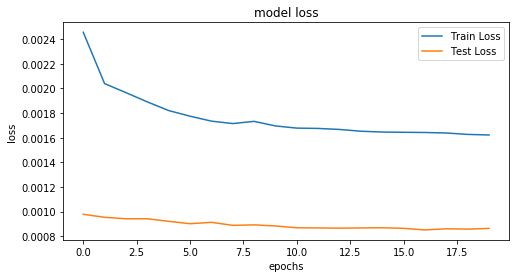

In [82]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

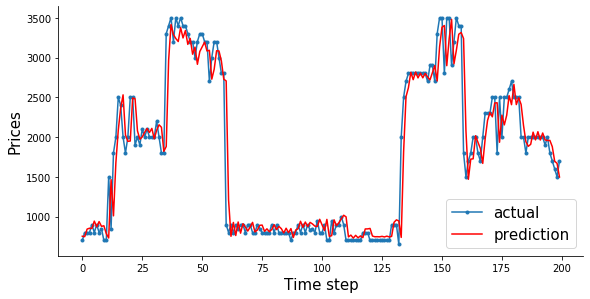

In [83]:
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Prices', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();